##Necessary Imports

In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

##UnZipping

In [2]:
!unzip "/content/Fire Segmentation Image Dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5374.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5375.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5376.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5377.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5378.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5379.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_538.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5380.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5381.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5382.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5383.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5384.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5385.jpg  
  inflating: /content/dataset/Segmentation_Mask/Fire/Img_5386.jpg 

##Split Dataset into Train & Validation

In [3]:
img_dir = "/content/dataset/Image/Fire"
mask_dir = "/content/dataset/Segmentation_Mask/Fire"

base_dir = "/content/dataset_split"
train_img_dir = os.path.join(base_dir, "train/Image")
train_mask_dir = os.path.join(base_dir, "train/Segmentation_Mask")
val_img_dir   = os.path.join(base_dir, "val/Image")
val_mask_dir  = os.path.join(base_dir, "val/Segmentation_Mask")

#Create Folders
for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
    os.makedirs(d, exist_ok=True)

images = sorted(os.listdir(img_dir))
masks  = sorted(os.listdir(mask_dir))

#Same Seed for Reproducibility
random.seed(42)
indices = list(range(len(images)))
random.shuffle(indices)

split_idx = int(0.8 * len(indices))
train_idx, val_idx = indices[:split_idx], indices[split_idx:]

#Copy
for i in train_idx:
    shutil.copy(os.path.join(img_dir, images[i]), os.path.join(train_img_dir, images[i]))
    shutil.copy(os.path.join(mask_dir, masks[i]), os.path.join(train_mask_dir, masks[i]))

for i in val_idx:
    shutil.copy(os.path.join(img_dir, images[i]), os.path.join(val_img_dir, images[i]))
    shutil.copy(os.path.join(mask_dir, masks[i]), os.path.join(val_mask_dir, masks[i]))

print("Train images:", len(os.listdir(train_img_dir)))
print("Val images:", len(os.listdir(val_img_dir)))

Train images: 21968
Val images: 5492


##Data Loader

In [4]:
#Configuration
IMG_SIZE = (128, 128)
BATCH_SIZE = 8
EPOCHS = 50

def load_image(path, img_size=(128,128)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_mask(path, img_size=(128,128)):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method="nearest")
    mask = tf.cast(mask > 0, tf.float32)
    return mask

def make_dataset(img_dir, mask_dir, batch_size=8, img_size=(128,128)):
    img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    print("Total images:", len(img_files), " | Total masks:", len(mask_files))

    ds = tf.data.Dataset.from_tensor_slices((img_files, mask_files))
    ds = ds.map(lambda i, m: (load_image(i, img_size), load_mask(m, img_size)))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_img_dir, train_mask_dir, BATCH_SIZE, IMG_SIZE)
val_ds   = make_dataset(val_img_dir, val_mask_dir, BATCH_SIZE, IMG_SIZE)

Total images: 21968  | Total masks: 21968
Total images: 5492  | Total masks: 5492


##U Net

In [5]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def unet(input_shape=(128,128,3)):
    inputs = keras.Input(shape=input_shape)

#Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

#Bottleneck
    b = conv_block(p2, 128)

#Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.concatenate([u1, c2])
    c3 = conv_block(u1, 64)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = conv_block(u2, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c4)

    return keras.Model(inputs, outputs)

model = unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

##Training

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - accuracy: 0.9630 - loss: 0.1581 - val_accuracy: 0.9800 - val_loss: 0.0594
Epoch 2/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 71s 22ms/step - accuracy: 0.9814 - loss: 0.0500 - val_accuracy: 0.9802 - val_loss: 0.0558
Epoch 3/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9821 - loss: 0.0473 - val_accuracy: 0.9807 - val_loss: 0.0557
Epoch 4/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 76s 20ms/step - accuracy: 0.9825 - loss: 0.0457 - val_accuracy: 0.9810 - val_loss: 0.0519
Epoch 5/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.9829 - loss: 0.0442 - val_accuracy: 0.9802 - val_loss: 0.0532
Epoch 6/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.9833 - loss: 0.0431 - val_accuracy: 0.9815 - val_loss: 0.0495
Epoch 7/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 83s 20ms/step - accuracy: 0.9834 - loss: 0.0424 - val_accuracy: 0.9789 - val_loss: 0.0562
Epoch 8/50
2746/2746 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9838 -

##Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

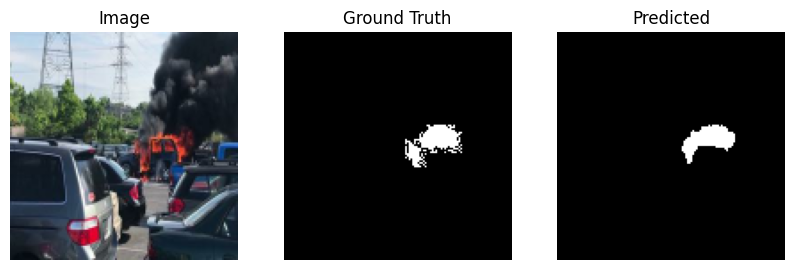

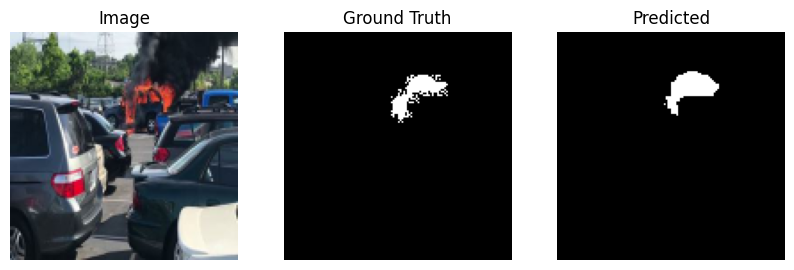

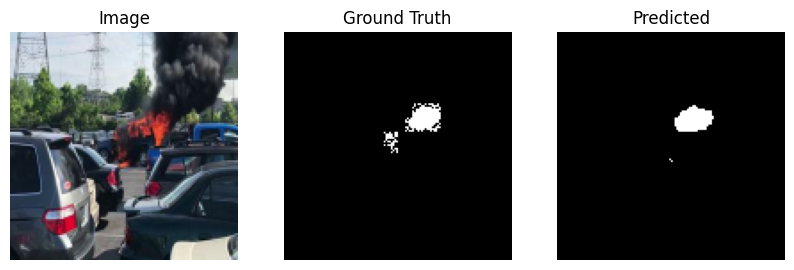

In [7]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)

for imgs, masks in val_ds:
    preds = model.predict(imgs)
    preds_bin = tf.cast(preds > 0.5, tf.int32)
    masks_bin = tf.cast(masks, tf.int32)

#Update Metrics
    precision.update_state(masks_bin, preds_bin)
    recall.update_state(masks_bin, preds_bin)
    mean_iou.update_state(masks_bin, preds_bin)

#Extract Results
prec = precision.result().numpy()
rec = recall.result().numpy()
iou = mean_iou.result().numpy()
f1 = 2 * (prec * rec) / (prec + rec + 1e-6)

print("Evaluation Results:")
print("Mean IoU       :", iou)
print("Mean Precision :", prec)
print("Mean Recall    :", rec)
print("Mean F1-score  :", f1)


#Visualization
for imgs, masks in val_ds.take(1):
    preds = model.predict(imgs)
    for i in range(3):
        plt.figure(figsize=(10,3))

        plt.subplot(1,3,1)
        plt.imshow(imgs[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(tf.squeeze(masks[i]), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(tf.squeeze(preds[i] > 0.5), cmap="gray")
        plt.title("Predicted")
        plt.axis("off")

        plt.show()


##Model Saving

In [9]:
#Save
model_h5_path = "/content/fire_segmentation_model.h5"
model.save(model_h5_path)
print(f"Model saved as H5 at: {model_h5_path}")

#Download
from google.colab import files
files.download(model_h5_path)


Model saved as H5 at: /content/fire_segmentation_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Prdiction

In [10]:
def predict_fire(image_path, model, img_size=(128,128), visualize=True):

#Load & preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    img_input = tf.expand_dims(img, axis=0)

#Prediction
    pred = model.predict(img_input)[0]
    pred_mask = tf.cast(pred > 0.5, tf.float32).numpy()

    if visualize:
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(pred_mask[:,:,0], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()

    return pred_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


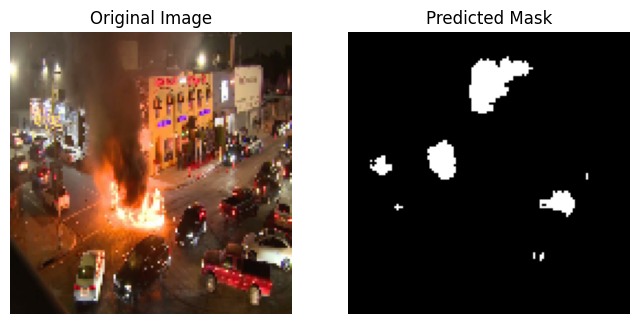

In [12]:
image_path = "/content/download.jpg"
predicted_mask = predict_fire(image_path, model)